<a href="https://colab.research.google.com/github/shwetadahiwal/Email-Spam-Detection-With-Machine-Learning/blob/main/Email_Spam_Detection_With_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# **Loading Data**

In [ ]:
raw_mail_data = pd.read_csv("spam.csv",encoding="latin1")

In [ ]:
mail_data = raw_mail_data.where((pd.notnull(raw_mail_data)), '')

In [ ]:
mail_data.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",,,
1,ham,Ok lar... Joking wif u oni...,,,
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,,,
3,ham,U dun say so early hor... U c already then say...,,,
4,ham,"Nah I don't think he goes to usf, he lives aro...",,,


In [ ]:
mail_data.shape

(5572, 5)

In [ ]:
mail_data['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [ ]:
dataset["labels"].value_counts()

0    4825
1     747
Name: labels, dtype: int64

# **Encoding Category Column**

> - Spam mail label as 1 and Ham mail label as 0



In [ ]:
mail_data.loc[mail_data['v1'] == 'ham', 'v1_Label'] = 0
mail_data.loc[mail_data['v1'] == 'spam', 'v1_Label'] = 1

In [ ]:
mail_data.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,v1_Label
0,ham,"Go until jurong point, crazy.. Available only ...",,,,0.0
1,ham,Ok lar... Joking wif u oni...,,,,0.0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,,,,1.0
3,ham,U dun say so early hor... U c already then say...,,,,0.0
4,ham,"Nah I don't think he goes to usf, he lives aro...",,,,0.0


In [ ]:
X = mail_data['v2'].values
Y = mail_data['v1_Label'].values

# **Preparing training and testing set**

In [ ]:
X = mail_data['v2'].values
Y = mail_data['v1_Label'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, shuffle=True)

In [ ]:
print("Original data size:", X.shape[0])
print("Train data size:", X_train.shape[0])
print("Test data size:", X_test.shape[0])

Original data size: 5572
Train data size: 4457
Test data size: 1115


# **Text feature extraction using TF-IDF Vectorizer**

In [ ]:
vectorizer = TfidfVectorizer(min_df=1, lowercase=True, stop_words='english')

In [ ]:
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

# **Model selection and hyper-parameter tuning using GridSearchCV**

In [ ]:
models = {
    "svm_linear": {
        "instance": SVC(probability=True, gamma="auto", kernel="linear"),
        "params": {
            "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        }
    },
    "logistic_regression": {
        "instance": LogisticRegression(max_iter=500),
        "params": {
            "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        }
    },
}

In [ ]:
scores = []
best_estimators = {}

for model_name, config in models.items():
    print("Training", model_name)
    
    classifier = GridSearchCV(
        estimator=config["instance"],
        param_grid=config["params"],
        cv=5,
        scoring="accuracy"
    )
    
    classifier.fit(X_train_features, y_train)
    
    scores.append({
        "model" : model_name,
        "train_score" : classifier.best_score_,
        "test_score" : classifier.best_estimator_.score(X_test_features, y_test),
        "params" : classifier.best_params_
    })
    
    best_estimators[model_name] = classifier.best_estimator_

Training svm_linear
Training logistic_regression


In [ ]:
result = pd.DataFrame(scores, columns=["model", "train_score", "test_score", "params"])
result.head()

,model,train_score,test_score,params
0,svm_linear,0.975547,0.991928,{'C': 1}
1,logistic_regression,0.975547,0.992825,{'C': 1000}


In [ ]:
model = best_estimators['logistic_regression']

# **Model evaluation**

In [ ]:
print("ACCURACY SCORE")
print("Training Set:", accuracy_score(y_true=y_train, y_pred=model.predict(X_train_features)) * 100, "%")
print("Testing Set:", accuracy_score(y_true=y_test, y_pred=model.predict(X_test_features)) * 100, "%")

ACCURACY SCORE
Training Set: 100.0 %
Testing Set: 99.28251121076234 %


In [ ]:
print("CLASSIFICATION REPORT")
print(classification_report(y_true=y_test, y_pred=model.predict(X_test_features)))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       976
         1.0       1.00      0.94      0.97       139

    accuracy                           0.99      1115
   macro avg       1.00      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



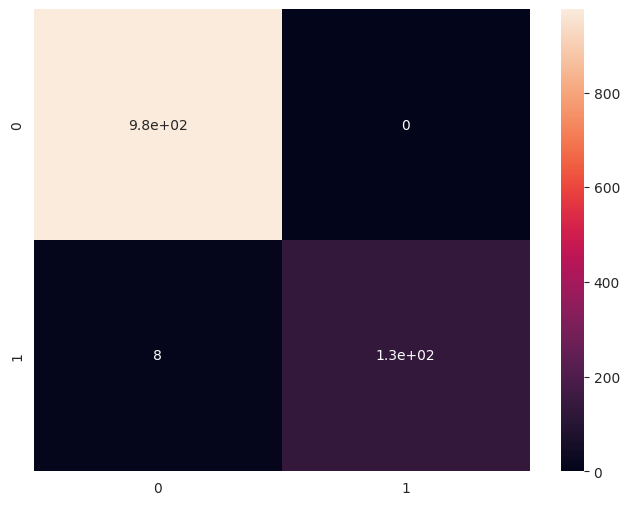

In [ ]:
matrix = confusion_matrix(y_true=y_test, y_pred=model.predict(X_test_features))

plt.figure(figsize=(8,6))
plt.xlabel("PREDICTED")
plt.ylabel("TRUTH")
sns.heatmap(matrix, annot=True)
plt.show()


In [ ]:
predictions = pd.DataFrame()

predictions["Content"] = X_test

predictions["Real Category"] = y_test
predictions["Predicted Category"] = model.predict(X_test_features)

predictions.loc[predictions['Real Category'] == 0, 'Real Category'] = 'Ham'
predictions.loc[predictions['Real Category'] == 1, 'Real Category'] = 'Spam'

predictions.loc[predictions['Predicted Category'] == 0, 'Predicted Category'] = 'Ham'
predictions.loc[predictions['Predicted Category'] == 1, 'Predicted Category'] = 'Spam'

predictions.to_csv("test_prediction_result.csv", index=False)

predictions.head(10)

,Content,Real Category,Predicted Category
0,Convey my regards to him,Ham,Ham
1,"[Û_] anyway, many good evenings to u! s",Ham,Ham
2,My sort code is and acc no is . The bank is n...,Ham,Ham
3,Sorry i din lock my keypad.,Ham,Ham
4,"Hi babe its Chloe, how r u? I was smashed on s...",Spam,Spam
5,Ok i thk i got it. Then u wan me 2 come now or...,Ham,Ham
6,Oi when you gonna ring,Ham,Ham
7,Will be office around 4 pm. Now i am going hos...,Ham,Ham
8,Have you heard about that job? I'm going to th...,Ham,Ham
9,Oh my God. I'm almost home,Ham,Ham
